In [2]:
# Download the lambda virus genome
import wget
url = 'https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/lambda_virus.fa'
filename = wget.download(url)

Now lets load all the functions we need to work on the genome:

In [3]:
def naive(p, t):
    occurrences = []
    for i in range(len(t) - len(p) + 1):  # loop over alignments
        match = True
        for j in range(len(p)):  # loop over characters
            if t[i+j] != p[j]:  # compare characters
                match = False
                break
        if match:
            occurrences.append(i)  # all chars matched; record
    return occurrences

In [4]:
def reverseComplement(s):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N': 'N'}
    t = ''
    for base in s:
        t = complement[base] + t
    return t

In [5]:
def readGenome(filename):
    genome = ''
    with open(filename, 'r') as f:
        for line in f:
            # ignore header line with genome information
            if not line[0] == '>':
                genome += line.rstrip()
    return genome

In [6]:
def readFastq(filename):
    sequences = []
    qualities = []
    with open(filename) as fh:
        while True:
            fh.readline()  # skip name line
            seq = fh.readline().rstrip()  # read base sequence
            fh.readline()  # skip placeholder line
            qual = fh.readline().rstrip() # base quality line
            if len(seq) == 0:
                break
            sequences.append(seq)
            qualities.append(qual)
    return sequences, qualities

Now lets make a version of the naive matching algorithm that uses the reverse complement

In [7]:
def naive_with_rc(p,t):
    p = reverseComplement(p)
    occurrences = []
    for i in range(len(t) - len(p) + 1):  # loop over alignments
        match = True
        for j in range(len(p)):  # loop over characters
            if t[i+j] != p[j]:  # compare characters
                match = False
                break
        if match:
            occurrences.append(i)  # all chars matched; record
    return occurrences

In [8]:
naive_with_rc("ATC","ATCAGGTGCTGGCTAGATC"),naive("ATC","ATCAGGTGCTGGCTAGATC")

([15], [0, 16])

Combine them to make a function that finds both forward and reverse complement matching, at unique positions in the genome. E.g. reverse complement palindromes only match once, not twice.

In [9]:
def naive_bothstrand(p,t):
    return list(set(naive(p,t)  + naive_with_rc(p,t)))

In [10]:
naive_bothstrand("AACGTT","ATCAGGAACGTTTAGATC")

[6]

The function seems to be working. Let's go on to the quiz.
First read the lambda_virus genome

In [11]:
genome = readGenome(filename)

1.
**Question 1**  
How many times does AGGT or its reverse complement ACCT occur in the lambda virus genome?  E.g. if AGGT occurs 10 times and ACCT occurs 12 times, you should report 22.


In [12]:
len(naive('AGGT', genome)) + len(naive_with_rc('AGGT', genome))

306

2.
**Question 2**
How many times does TTAA or its reverse complement occur in the lambda virus genome?  

*Hint*: TTAA and its reverse complement are equal, so remember not to double count.


In [13]:
len(naive_bothstrand("TTAA",genome))

195

**Question 3**  What is the offset of the leftmost occurrence of **ACTAAGT** or its reverse complement in the Lambda virus genome?  E.g. if the leftmost occurrence of **ACTAAGT** is at offset 40 (0-based) and the leftmost occurrence of its reverse complement **ACTTAGT** is at offset 29, then report 29.

In [14]:
min(naive_bothstrand("ACTTAGT",genome))

26028

**Question 4**  What is the offset of the leftmost occurrence of **AGTCGA** or its reverse complement in the Lambda virus genome?

In [15]:
min(naive_bothstrand("AGTCGA",genome))

450

**Question 5**  As we will discuss, sometimes we would like to find approximate matches for P in T. That is, we want to find occurrences with one or more differences.
For Questions 5 and 6, make a new version of the **naive** function called **naive_2mm** that allows up to 2 mismatches per occurrence. Unlike for the previous questions, do not consider the reverse complement here.  We're looking for approximate matches for P itself, not its reverse complement.

In [16]:
def naive_2mm(p, t):
    occurrences = []
    for i in range(len(t) - len(p) + 1):  # loop over alignments
        match = True
        mismatch = 0
        for j in range(len(p)):  # loop over characters
            if t[i+j] != p[j]:
                mismatch += 1
                if mismatch > 2:
                    match = False
                    break
        if match:
            occurrences.append(i)  # all chars matched; record
    return occurrences

In [17]:
naive_2mm('ACTTTA', 'ACTTACTTGATAAAGT')

[0, 4]

**Question 5** How many times does TTCAAGCC occur in the Lambda virus genome when allowing up to 2 mismatches? 

In [18]:
len(naive_2mm("TTCAAGCC", genome))

191

**Question 6**  
What is the offset of the leftmost occurrence of AGGAGGTT in the Lambda virus genome when allowing up to 2 mismatches?

In [19]:
min(naive_2mm("AGGAGGTT", genome))

49

**Question 7**  
Finally, download and parse the provided FASTQ file containing real DNA sequencing reads derived from a human:

In [20]:
# Download DNA reads
import wget
url = 'https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR037900_1.first1000.fastq'
filename = wget.download(url)
seqs, quals = readFastq(filename)

In [21]:
def phred33ToQ(qual):
    return ord(qual) - 33

In [22]:
# We can use the reads quality function already defined for us in the class
def createHist(qualities):
    # Create a histogram of quality scores
    hist = [0]*50
    for qual in qualities:
        for phred in qual:
            q = phred33ToQ(phred)
            hist[q] += 1
    return hist
h = createHist(quals)

In [27]:
len(quals)

1000

In [32]:
def checkPosQualities(qualities):
    # For each position (0-100) in the reads, add all the qualities
    # At that position and divide with number of reads to get average.
    position_average = [0]*100
    for qual in qualities:
        i = 0
        for phred in qual:
            position_average[i] += phred33ToQ(phred)
            i += 1
    # Get average and return
    return [x / len(qualities) for x in position_average]


pos_avg = checkPosQualities(quals)
print(pos_avg/1000)


TypeError: unsupported operand type(s) for /: 'list' and 'int'

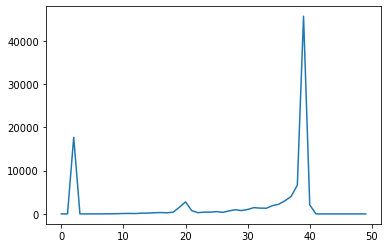

In [24]:
# Plot the histogram
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(len(h)), h)
plt.show()